In [ ]:
! pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files

# Upload kaggle.json
uploaded = files.upload()

# Move it to the correct directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Set correct permissions
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets download ashenafifasilkebede/dataset


Dataset URL: https://www.kaggle.com/datasets/ashenafifasilkebede/dataset
License(s): CC0-1.0


In [ ]:
! unzip -o dataset.zip


Streaming output truncated to the last 5000 lines.
  inflating: train/Normal/Normal_100x_85.jpg  
  inflating: train/Normal/Normal_100x_86.jpg  
  inflating: train/Normal/Normal_100x_87.jpg  
  inflating: train/Normal/Normal_100x_89.jpg  
  inflating: train/Normal/Normal_100x_9.jpg  
  inflating: train/Normal/Normal_400x_1.jpg  
  inflating: train/Normal/Normal_400x_100.jpg  
  inflating: train/Normal/Normal_400x_101.jpg  
  inflating: train/Normal/Normal_400x_102.jpg  
  inflating: train/Normal/Normal_400x_103.jpg  
  inflating: train/Normal/Normal_400x_107.jpg  
  inflating: train/Normal/Normal_400x_108.jpg  
  inflating: train/Normal/Normal_400x_109.jpg  
  inflating: train/Normal/Normal_400x_11.jpg  
  inflating: train/Normal/Normal_400x_110.jpg  
  inflating: train/Normal/Normal_400x_111.jpg  
  inflating: train/Normal/Normal_400x_112.jpg  
  inflating: train/Normal/Normal_400x_113.jpg  
  inflating: train/Normal/Normal_400x_114.jpg  
  inflating: train/Normal/Normal_400x_115.jpg 

In [ ]:
!pip install torch torchvision matplotlib opencv-python numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load Pre-trained ResNet50 model
model = models.resnet50(pretrained=True)
model.eval()

# Set the model to use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_image(image_path):
    """Load and preprocess an image for model input."""
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    return image


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 144MB/s]


In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register forward and backward hooks
        self.target_layer.register_forward_hook(self.forward_hook)
        self.target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activations = output  # Save activations

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]  # Save gradients

    def generate_cam(self, image, class_idx=None):
        # Forward pass
        output = self.model(image)
        if class_idx is None:
            class_idx = output.argmax().item()

        # Backward pass
        self.model.zero_grad()
        output[:, class_idx].backward()

        # Compute Grad-CAM
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = torch.nn.functional.relu(cam)

        # Normalize and resize
        cam = cam.squeeze().cpu().detach().numpy()
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min())  # Normalize

        return cam


In [ ]:
def get_bounding_boxes(heatmap, threshold=0.6):
    """
    Extract bounding boxes from the heatmap.
    - `threshold`: Defines how much of the heatmap should be considered.
    """
    # Convert heatmap to binary mask (0s and 1s)
    binary_map = (heatmap > threshold).astype(np.uint8) * 255

    # Find contours (connected components in the binary map)
    contours, _ = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get bounding boxes around the detected regions
    boxes = [cv2.boundingRect(cnt) for cnt in contours]

    return boxes


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


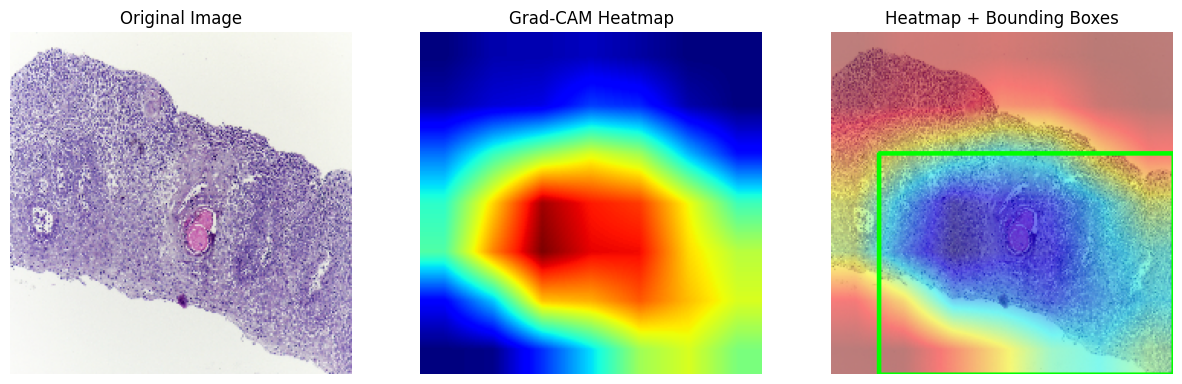

In [ ]:
# Load image
image_path = "/content/train/OSCC/OSCC_100x_1.jpg"  # Change this to your OSCC image
image = preprocess_image(image_path)

# Select the last convolutional layer in ResNet-50
target_layer = model.layer4[-1]

# Create Grad-CAM object
grad_cam = GradCAM(model, target_layer)

# Generate CAM heatmap
heatmap = grad_cam.generate_cam(image)

# Get bounding boxes from the heatmap
boxes = get_bounding_boxes(heatmap, threshold=0.6)

# Load original image
original = cv2.imread(image_path)
original = cv2.resize(original, (224, 224))
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

# Overlay heatmap on original image
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(original, 0.5, heatmap_colored, 0.5, 0)

# Draw bounding boxes on the image
for (x, y, w, h) in boxes:
    cv2.rectangle(overlay, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(original)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(heatmap, cmap="jet")
ax[1].set_title("Grad-CAM Heatmap")
ax[1].axis("off")

ax[2].imshow(overlay)
ax[2].set_title("Heatmap + Bounding Boxes")
ax[2].axis("off")

plt.show()


In [ ]:
import json
import os

# Define dataset structure
annotations = {"images": [], "annotations": [], "categories": [{"id": 1, "name": "OSCC"}]}
annotation_id = 1

# Define dataset folder and save path
dataset_folder = "/content/train/OSCC"
output_json = "oscc_annotations.json"

# Process each image in the dataset
for idx, image_name in enumerate(os.listdir(dataset_folder)):
    image_path = os.path.join(dataset_folder, image_name)

    # Preprocess Image
    image = preprocess_image(image_path)

    # Generate CAM heatmap
    heatmap = grad_cam.generate_cam(image)

    # Get bounding boxes
    boxes = get_bounding_boxes(heatmap, threshold=0.6)

    # Skip images with no detected bounding boxes
    if len(boxes) == 0:
        continue

    # Save image info
    image_id = idx + 1
    annotations["images"].append({
        "id": image_id,
        "file_name": image_name,
        "width": 224,
        "height": 224
    })

    # Save bounding boxes
    for (x, y, w, h) in boxes:
        bbox = [x, y, w, h]  # COCO format (x, y, width, height)
        annotations["annotations"].append({
            "id": annotation_id,
            "image_id": image_id,
            "bbox": bbox,
            "category_id": 1,
            "area": w * h,
            "iscrowd": 0
        })
        annotation_id += 1

# Save to JSON
with open(output_json, "w") as f:
    json.dump(annotations, f, indent=4)

print(f"Annotations saved to {output_json}")


Annotations saved to oscc_annotations.json


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import os
import json
import cv2
from torch.utils.data import DataLoader, Dataset

# Custom Dataset for Faster R-CNN
class OSCCDataset(Dataset):
    def __init__(self, annotation_file, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        with open(annotation_file) as f:
            self.data = json.load(f)

        self.image_info = {img["id"]: img for img in self.data["images"]}
        self.annotations = {img["id"]: [] for img in self.data["images"]}
        for ann in self.data["annotations"]:
            self.annotations[ann["image_id"]].append(ann)

    def __len__(self):
        return len(self.image_info)

    def __getitem__(self, idx):
        image_id = list(self.image_info.keys())[idx]
        img_path = os.path.join(self.image_dir, self.image_info[image_id]["file_name"])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        boxes = []
        labels = []
        for ann in self.annotations.get(image_id, []):
            x, y, w, h = ann["bbox"]
            boxes.append([x, y, x + w, y + h])
            labels.append(ann["category_id"])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels, "image_id": torch.tensor([image_id])}

        if self.transform:
            image = self.transform(image)

        return image, target

# Define dataset paths
dataset_path = "/content/train/OSCC"
train_json = "oscc_annotations.json"
train_images = dataset_path

# Image transformations
transform = transforms.Compose([transforms.ToTensor()])

# Create dataset
train_dataset = OSCCDataset(train_json, train_images, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))


In [ ]:
# Load Pretrained Faster R-CNN
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Modify the classifier to match the number of classes (1 class + background)
num_classes = 2  # OSCC + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 150MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
import torch.optim as optim

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

# Save trained model
torch.save(model.state_dict(), "faster_rcnn_oscc.pth")
print("Model saved as faster_rcnn_oscc.pth")


Epoch 1/10, Loss: 417.5901
Epoch 2/10, Loss: 406.0108
Epoch 3/10, Loss: 389.4192
Epoch 4/10, Loss: 388.8096
Epoch 5/10, Loss: 387.9714
Epoch 6/10, Loss: 378.9054
Epoch 7/10, Loss: 381.9555
Epoch 8/10, Loss: 379.0650
Epoch 9/10, Loss: 370.4999
Epoch 10/10, Loss: 363.6822
Model saved as faster_rcnn_oscc.pth


In [ ]:
import torchvision.transforms as T

class OSCCDataset(Dataset):
    def __init__(self, annotation_file, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform if transform else T.ToTensor()  # ✅ Convert PIL to Tensor

        with open(annotation_file) as f:
            self.data = json.load(f)

        self.image_info = {img["id"]: img for img in self.data["images"]}
        self.annotations = {ann["image_id"]: [] for ann in self.data["annotations"]}
        for ann in self.data["annotations"]:
            self.annotations[ann["image_id"]].append(ann)

    def __len__(self):
        return len(self.image_info)

    def __getitem__(self, idx):
        image_id = list(self.image_info.keys())[idx]
        img_path = os.path.join(self.image_dir, self.image_info[image_id]["file_name"])

        # ✅ Load using PIL
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"❌ Error loading image {img_path}: {e}")
            return None

        # ✅ Convert to tensor
        image = self.transform(image)

        boxes = []
        labels = []
        for ann in self.annotations.get(image_id, []):
            x_min, y_min, width, height = ann["bbox"]
            boxes.append([x_min, y_min, x_min + width, y_min + height])
            labels.append(ann["category_id"])

        # Convert to tensor
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}
        return image, target


In [ ]:
# ✅ Reload dataset
test_dataset = OSCCDataset("/content/oscc_annotations.json", "/content/test/OSCC")

# ✅ Reload DataLoader
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# ✅ Check batch loading
for batch in test_loader:
    images, targets = batch
    print(f"✅ Loaded a batch with {len(images)} images.")
    break

# ✅ Run mAP@50 calculation
map50 = calculate_map50(model, test_loader)
print(f"🔥 mAP@50: {map50:.4f}")


✅ Loaded a batch with 4 images.
🔥 mAP@50: 0.0768


# **YOLO**

In [ ]:
!pip install torch torchvision matplotlib opencv-python numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load Pre-trained ResNet50 model
model = models.resnet50(pretrained=True)
model.eval()

# Set the model to use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_image(image_path):
    """Load and preprocess an image for model input."""
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    return image


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 82.9MB/s]


In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register forward and backward hooks
        self.target_layer.register_forward_hook(self.forward_hook)
        self.target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activations = output  # Save activations

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]  # Save gradients

    def generate_cam(self, image, class_idx=None):
        # Forward pass
        output = self.model(image)
        if class_idx is None:
            class_idx = output.argmax().item()

        # Backward pass
        self.model.zero_grad()
        output[:, class_idx].backward()

        # Compute Grad-CAM
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = torch.nn.functional.relu(cam)

        # Normalize and resize
        cam = cam.squeeze().cpu().detach().numpy()
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min())  # Normalize

        return cam


In [ ]:
def get_bounding_boxes(heatmap, threshold=0.6):
    """
    Extract bounding boxes from the heatmap.
    - `threshold`: Defines how much of the heatmap should be considered.
    """
    # Convert heatmap to binary mask (0s and 1s)
    binary_map = (heatmap > threshold).astype(np.uint8) * 255

    # Find contours (connected components in the binary map)
    contours, _ = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get bounding boxes around the detected regions
    boxes = [cv2.boundingRect(cnt) for cnt in contours]

    return boxes


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


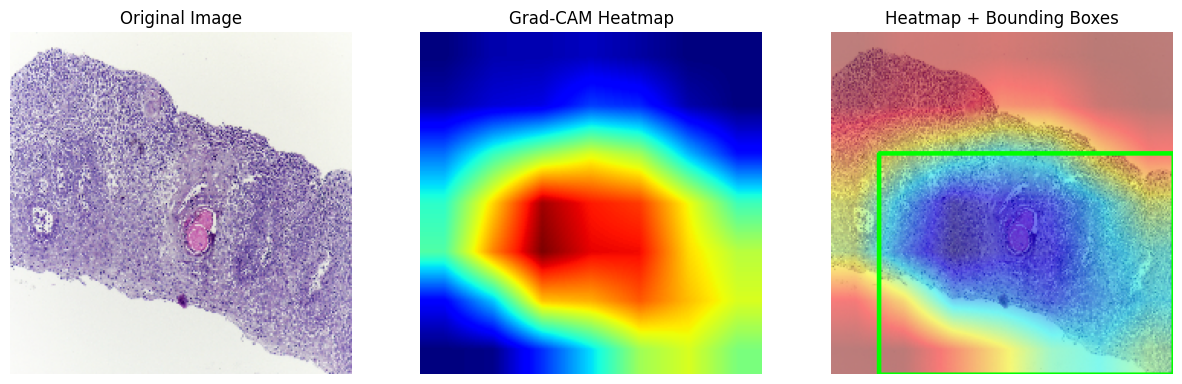

In [ ]:
# Load image
image_path = "/content/train/OSCC/OSCC_100x_1.jpg"  # Change this to your OSCC image
image = preprocess_image(image_path)

# Select the last convolutional layer in ResNet-50
target_layer = model.layer4[-1]

# Create Grad-CAM object
grad_cam = GradCAM(model, target_layer)

# Generate CAM heatmap
heatmap = grad_cam.generate_cam(image)

# Get bounding boxes from the heatmap
boxes = get_bounding_boxes(heatmap, threshold=0.6)

# Load original image
original = cv2.imread(image_path)
original = cv2.resize(original, (224, 224))
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

# Overlay heatmap on original image
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(original, 0.5, heatmap_colored, 0.5, 0)

# Draw bounding boxes on the image
for (x, y, w, h) in boxes:
    cv2.rectangle(overlay, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(original)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(heatmap, cmap="jet")
ax[1].set_title("Grad-CAM Heatmap")
ax[1].axis("off")

ax[2].imshow(overlay)
ax[2].set_title("Heatmap + Bounding Boxes")
ax[2].axis("off")

plt.show()


In [ ]:
import os

def save_yolo_annotation(image_path, boxes, output_dir="yolo_labels"):
    """Convert bounding boxes to YOLO format and save as .txt file."""
    img = cv2.imread(image_path)
    h, w, _ = img.shape  # Get image dimensions

    # Create output directory if not exists
    os.makedirs(output_dir, exist_ok=True)

    # Generate YOLO format annotations
    yolo_annotations = []
    for (x, y, bw, bh) in boxes:
        x_center = (x + bw / 2) / w
        y_center = (y + bh / 2) / h
        bw /= w
        bh /= h
        yolo_annotations.append(f"0 {x_center} {y_center} {bw} {bh}")  # '0' is class_id

    # Save annotation file
    txt_filename = os.path.join(output_dir, os.path.basename(image_path).replace(".jpg", ".txt"))
    with open(txt_filename, "w") as f:
        f.write("\n".join(yolo_annotations))

    print(f"Saved: {txt_filename}")


In [ ]:
import glob

def process_folder(image_folder, output_dir="yolo_labels"):
    """Process all images in the folder, generate heatmaps, and save YOLO annotations."""
    os.makedirs(output_dir, exist_ok=True)  # Create output directory if not exists
    image_paths = glob.glob(os.path.join(image_folder, "*.jpg"))  # Get all .jpg images

    for image_path in image_paths:
        try:
            image = preprocess_image(image_path)  # Preprocess image for Grad-CAM
            heatmap = grad_cam.generate_cam(image)  # Generate heatmap
            boxes = get_bounding_boxes(heatmap, threshold=0.6)  # Get bounding boxes

            if boxes:  # Only save if boxes are detected
                save_yolo_annotation(image_path, boxes, output_dir)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

    print("✅ Batch processing complete!")


In [ ]:
image_folder = "/content/train/OSCC"  # Change this to your OSCC image folder
process_folder(image_folder)


Saved: yolo_labels/OSCC_400x_407.txt
Saved: yolo_labels/aug_483_397.txt
Saved: yolo_labels/OSCC_400x_293.txt
Saved: yolo_labels/aug_276_1643.txt
Saved: yolo_labels/aug_127_751.txt
Saved: yolo_labels/aug_276_677.txt
Saved: yolo_labels/aug_168_2621.txt
Saved: yolo_labels/OSCC_100x_416.txt
Saved: yolo_labels/OSCC_100x_100.txt
Saved: yolo_labels/aug_173_3677.txt
Saved: yolo_labels/aug_659_9248.txt
Saved: yolo_labels/OSCC_100x_105.txt
Saved: yolo_labels/OSCC_400x_164.txt
Saved: yolo_labels/aug_435_3907.txt
Saved: yolo_labels/OSCC_100x_345.txt
Saved: yolo_labels/OSCC_400x_198.txt
Saved: yolo_labels/aug_506_9367.txt
Saved: yolo_labels/aug_117_6137.txt
Saved: yolo_labels/aug_76_1208.txt
Saved: yolo_labels/aug_569_6665.txt
Saved: yolo_labels/OSCC_400x_357.txt
Saved: yolo_labels/OSCC_400x_109.txt
Saved: yolo_labels/aug_331_2341.txt
Saved: yolo_labels/aug_309_8379.txt
Saved: yolo_labels/OSCC_400x_334.txt
Saved: yolo_labels/aug_232_3163.txt
Saved: yolo_labels/OSCC_100x_154.txt
Saved: yolo_labels/a

In [ ]:
!pip install ultralytics
!pip install opencv-python
!pip install torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 49.4 MB/s eta 0:00:00


In [ ]:
import torch
from ultralytics import YOLO


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
#dataset_path = "/content/train/OSCC"
import os
import shutil
import random

dataset_path = "/content/train/OSCC"  # Change to your folder
output_path = "/content/OSCC_YOLO"

images_folder = os.path.join(dataset_path, "images")  # Where all images are stored
labels_folder = "/content/yolo_labels"  # Where YOLO labels are stored
 # Change to your dataset folder


In [ ]:
# Create train/val directories
os.makedirs(os.path.join(output_path, "images/train"), exist_ok=True)
os.makedirs(os.path.join(output_path, "images/val"), exist_ok=True)
os.makedirs(os.path.join(output_path, "labels/train"), exist_ok=True)
os.makedirs(os.path.join(output_path, "labels/val"), exist_ok=True)


In [ ]:
import os
import shutil
import random

dataset_path = "/content/train/OSCC"  # Adjust based on actual structure
output_path = "/content/OSCC_YOLO"

# Check if images are inside "OSCC" directly or inside a subfolder
if os.path.exists(os.path.join(dataset_path, "images")):
    images_folder = os.path.join(dataset_path, "images")  # If images are in /images/
else:
    images_folder = dataset_path  # If images are directly inside OSCC

labels_folder = "/content/yolo_labels"  # Ensure label folder exists

# Ensure paths exist
assert os.path.exists(images_folder), f"❌ Image folder not found: {images_folder}"
assert os.path.exists(labels_folder), f"❌ Label folder not found: {labels_folder}"

# Create YOLO folder structure
os.makedirs(os.path.join(output_path, "images/train"), exist_ok=True)
os.makedirs(os.path.join(output_path, "images/val"), exist_ok=True)
os.makedirs(os.path.join(output_path, "labels/train"), exist_ok=True)
os.makedirs(os.path.join(output_path, "labels/val"), exist_ok=True)

# Get all image filenames
image_files = [f for f in os.listdir(images_folder) if f.endswith(".jpg")]
random.shuffle(image_files)  # Shuffle images for random split

split_idx = int(0.8 * len(image_files))  # 80% train, 20% val
train_images, val_images = image_files[:split_idx], image_files[split_idx:]

# Move images & labels
missing_labels = 0

for img in train_images:
    shutil.move(os.path.join(images_folder, img), os.path.join(output_path, "images/train", img))
    label_file = img.replace(".jpg", ".txt")
    if os.path.exists(os.path.join(labels_folder, label_file)):
        shutil.move(os.path.join(labels_folder, label_file), os.path.join(output_path, "labels/train", label_file))
    else:
        missing_labels += 1

for img in val_images:
    shutil.move(os.path.join(images_folder, img), os.path.join(output_path, "images/val", img))
    label_file = img.replace(".jpg", ".txt")
    if os.path.exists(os.path.join(labels_folder, label_file)):
        shutil.move(os.path.join(labels_folder, label_file), os.path.join(output_path, "labels/val", label_file))
    else:
        missing_labels += 1

print(f"✅ Dataset split completed!")
print(f"🔹 Train Images: {len(os.listdir(os.path.join(output_path, 'images/train')))}")
print(f"🔹 Val Images: {len(os.listdir(os.path.join(output_path, 'images/val')))}")
print(f"🔹 Train Labels: {len(os.listdir(os.path.join(output_path, 'labels/train')))}")
print(f"🔹 Val Labels: {len(os.listdir(os.path.join(output_path, 'labels/val')))}")
print(f"⚠️ Missing labels: {missing_labels}")


✅ Dataset split completed!
🔹 Train Images: 2008
🔹 Val Images: 503
🔹 Train Labels: 2008
🔹 Val Labels: 503
⚠️ Missing labels: 0


In [ ]:
yaml_content = """
path: /content/OSCC_YOLO
train: images/train
val: images/val
names: ["cancerous_region"]
"""
with open("oscc.yaml", "w") as file:
    file.write(yaml_content)


In [ ]:
# Load YOLOv8 model
model = YOLO("yolov8n.pt")  # You can use 'yolov8s.pt' for better accuracy

# Train the model
model.train(data="oscc.yaml", epochs=50, imgsz=640, batch=8, device="cuda")


100%|██████████| 6.25M/6.25M [00:00<00:00, 122MB/s]


Ultralytics 8.3.96 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=oscc.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=

100%|██████████| 755k/755k [00:00<00:00, 101MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 305MB/s]
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:260: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:265: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Co

AMP: checks passed ✅


train: Scanning /content/OSCC_YOLO/labels/train... 2008 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2008/2008 [00:00<00:00, 2270.45it/s]


train: New cache created: /content/OSCC_YOLO/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/OSCC_YOLO/labels/val... 503 images, 0 backgrounds, 0 corrupt: 100%|██████████| 503/503 [00:00<00:00, 1230.03it/s]


val: New cache created: /content/OSCC_YOLO/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/251 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       1/50       1.3G      1.654      2.886      1.935         24        640: 100%|██████████| 251/251 [01:18<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P        

                   all        503        722      0.199      0.191     0.0967     0.0329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/251 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       2/50      1.56G      1.685      2.633      1.929         22        640: 100%|██████████| 251/251 [01:13<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P        

                   all        503        722     0.0935      0.176     0.0454     0.0125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/251 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       3/50      1.58G      1.683      2.611      1.917         21        640: 100%|██████████| 251/251 [01:10<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P        

                   all        503        722      0.337      0.161        0.1     0.0332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/251 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       4/50      1.59G      1.663      2.577      1.892         23        640: 100%|██████████| 251/251 [01:07<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P        

                   all        503        722      0.338      0.166     0.0993     0.0317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/251 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       5/50      1.61G      1.621      2.506      1.863         20        640: 100%|██████████| 251/251 [01:09<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P        

                   all        503        722      0.327      0.159     0.0923     0.0303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/251 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       6/50      1.63G      1.569      2.475      1.821         23        640: 100%|██████████| 251/251 [01:08<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P        

                   all        503        722      0.357      0.172      0.115     0.0387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/251 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       7/50      1.64G      1.548      2.479      1.833         27        640: 100%|██████████| 251/251 [01:08<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P        

                   all        503        722      0.309      0.148     0.0869      0.025

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/251 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       8/50      1.66G      1.559       2.46      1.819         23        640: 100%|██████████| 251/251 [01:08<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P        

                   all        503        722      0.279       0.19      0.118     0.0419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/251 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       9/50      1.68G      1.536      2.447      1.812         30        640: 100%|██████████| 251/251 [01:10<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P        

                   all        503        722      0.347      0.169      0.107     0.0343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/251 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      10/50       1.7G      1.488      2.409      1.792         24        640: 100%|██████████| 251/251 [01:09<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P        

                   all        503        722      0.353      0.169      0.104     0.0356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/251 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      11/50      1.71G      1.517      2.456      1.809         25        640: 100%|██████████| 251/251 [01:08<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P        

                   all        503        722      0.349      0.168      0.125      0.042



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/251 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      12/50      1.73G      1.496      2.404      1.786         15        640: 100%|██████████| 251/251 [01:09<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P        

                   all        503        722      0.395      0.137      0.134     0.0459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/251 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      13/50      1.75G      1.483      2.403      1.775         22        640: 100%|██████████| 251/251 [01:08<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P        

                   all        503        722      0.354      0.172      0.124     0.0431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/251 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      14/50      1.77G      1.475      2.395      1.772         14        640: 100%|██████████| 251/251 [01:07<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P        

                   all        503        722      0.344      0.166      0.119     0.0376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/251 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      15/50      1.78G      1.471        2.4      1.779         25        640: 100%|██████████| 251/251 [01:05<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P        

                   all        503        722      0.357       0.17      0.126     0.0426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/251 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      16/50       1.8G      1.438      2.391      1.751         20        640: 100%|██████████| 251/251 [01:09<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P        

                   all        503        722      0.369      0.179      0.119     0.0412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/251 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      17/50      1.81G      1.466      2.376      1.775         14        640: 100%|██████████| 251/251 [01:06<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P        

                   all        503        722      0.349      0.169      0.107      0.038



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/251 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      18/50      1.83G      1.438      2.373      1.755         24        640: 100%|██████████| 251/251 [01:07<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P        

                   all        503        722      0.359      0.173      0.135     0.0457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/251 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      19/50      1.85G      1.408      2.383      1.743         18        640: 100%|██████████| 251/251 [01:07<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P        

                   all        503        722      0.347      0.173      0.128      0.044



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/251 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      20/50      1.87G      1.413      2.385      1.759         18        640: 100%|██████████| 251/251 [01:07<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P        

                   all        503        722      0.351      0.162      0.114     0.0386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/251 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      21/50      1.88G      1.427      2.399      1.755         12        640: 100%|██████████| 251/251 [01:07<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P        

                   all        503        722      0.357      0.173      0.134     0.0465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/251 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      22/50       1.9G      1.404      2.352       1.74         21        640: 100%|██████████| 251/251 [01:06<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P        

                   all        503        722      0.354      0.175      0.126     0.0436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/251 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      23/50      1.92G      1.395      2.366      1.743         23        640: 100%|██████████| 251/251 [01:09<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P        

                   all        503        722      0.352      0.169      0.139     0.0493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/251 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      24/50      1.93G       1.38       2.32      1.735         21        640: 100%|██████████| 251/251 [01:06<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P        

                   all        503        722      0.346      0.175       0.13      0.045



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/251 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      25/50      1.95G      1.403      2.353      1.734         24        640: 100%|██████████| 251/251 [01:08<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P        

                   all        503        722      0.362       0.17      0.117     0.0421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/251 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      26/50      1.97G      1.388      2.324       1.72         25        640: 100%|██████████| 251/251 [01:07<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P        

                   all        503        722      0.359       0.16      0.126     0.0463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/251 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      27/50      1.99G      1.382      2.352      1.726         25        640: 100%|██████████| 251/251 [01:08<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P        

                   all        503        722      0.348      0.168      0.127     0.0448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/251 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      28/50         2G      1.371      2.315      1.723         22        640: 100%|██████████| 251/251 [01:07<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P        

                   all        503        722      0.368      0.173      0.126     0.0449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/251 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      29/50      2.02G      1.356       2.25      1.707         19        640: 100%|██████████| 251/251 [01:08<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P        

                   all        503        722       0.36      0.175      0.133     0.0474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/251 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      30/50      2.04G      1.366      2.323      1.718         26        640: 100%|██████████| 251/251 [01:09<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P        

                   all        503        722      0.368      0.174      0.122     0.0439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/251 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      31/50      2.05G      1.344      2.295      1.707         25        640: 100%|██████████| 251/251 [01:07<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P        

                   all        503        722      0.363      0.175      0.133     0.0489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/251 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      32/50      2.07G      1.351      2.304      1.715         18        640: 100%|██████████| 251/251 [01:06<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P        

                   all        503        722      0.357      0.169      0.107     0.0387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/251 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      33/50      2.09G      1.337      2.282      1.715         36        640: 100%|██████████| 251/251 [01:07<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P        

                   all        503        722      0.346      0.172      0.125     0.0469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/251 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      34/50       2.1G      1.318      2.247      1.701         23        640:  12%|█▏        | 29/251 [00:08<00:41,  5.29it/s]

In [ ]:
model.val()
